# Introduction
This notebook runs TFT tensorflow2 version on the covid dataset. You can recreate the merged input file using the `Data preparation` notebook. For a fresh model training, remove any files from the `checkpoint` folder.


# Initial Setup
## Importing libraries

In [1]:
import tensorflow as tf
import os, gc, json
import pandas as pd
from pandas import to_datetime

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

2022-06-21 11:45:22.630668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import sys
sys.path.append( '../../../v0/' )
from script.utils import train_validation_test_split, scale_back, calculate_result, sumCases
from Class.Trainer import Trainer
from Class.ParameterManager import ParameterManager
from Class.DataProcessor import DataProcessor
from Class.Plotter import PlotResults, PlotWeights

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-21 11:45:28.555094: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 11:45:28.558834: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-21 11:45:28.604801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 11:45:28.604839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 11:45:28.609814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 11:45:28.609871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

If cuda out of memory

In [ ]:
# import torch
# gc.collect()
# torch.cuda.empty_cache()

## Adding google drive
Set `running_on_colab= True` if running on Google colab.

In [4]:
running_on_colab = False

if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My Drive/Projects/Covid/TF2

## Setting up folders
The current folder has the following structure

* Rurality_cut.csv
* config.json
* output
  * checkpoints
  * figures

In [5]:
from dataclasses import dataclass

@dataclass
class args:
    # folder where the cleaned feature file are at
    dataPath = 'Rurality_cut.csv'

    outputPath = 'output/'
    configPath = 'config.json'
    checkpoint = os.path.join(outputPath, 'checkpoints')
    restore = False

In [6]:
# output paths
checkpoint_folder = args.checkpoint
figure_folder = os.path.join(args.outputPath, "figures")

# this eventually creates output folder if it doesn't exist
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder, exist_ok=True)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder, exist_ok=True)

In [7]:
print(f'Loading config.json from {args.configPath}')
with open(args.configPath) as inputfile:
    config = json.load(inputfile)
    inputfile.close()

Loading config.json from config.json


## Load data

In [8]:
print(f'Loading input data from {args.dataPath}')
df = pd.read_csv(args.dataPath)
print(f'Input feature file shape {df.shape}')

Loading input data from Rurality_cut.csv
Input feature file shape (56700, 25)


In [9]:
df['Date'] = to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

# Pre-processing

## Parameter manager

In [10]:
parameterManager = ParameterManager(config)
print(f'Column mappings: {parameterManager.col_mappings}\n')

Column mappings: {'Static': ['AgeDist', 'AirPollution', 'Comorbidities', 'HealthDisp', 'Mobility', 'ResidentialDense'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'Comorbidities', 'HealthDisp', 'Mobility', 'ResidentialDense', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'VaccinationOne', 'SocialDist', 'Testing']}



## Train validation test split and Scaling

In [11]:
train_data, validation_data, test_data, target_scaler = train_validation_test_split(df, parameterManager, scale=True)
print(f'Number train data is {train_data.shape[0]}, validation {validation_data.shape[0]}, test {test_data.shape[0]}')

Number train data is 44380, validation 6160, test 6160


## Create batches

In [12]:
dataProcessor = DataProcessor(
    parameterManager.total_sequence_length, parameterManager.col_mappings, parameterManager.data_params
)

train_batch = dataProcessor.prepare_batch(train_data, train=True)
validation_batch = dataProcessor.prepare_batch(validation_data)

gc.collect()

2022-06-21 11:45:29.929596: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 11:45:29.929778: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 11:45:29.930806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 11:45:29.930847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 11:45:29.930886: I tensorflow/stream_executor/platfor

0

# Training

## Util

In [13]:
def plot_history(history:dict,  figure_path:str=None, show=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True)
    x = range(1, len(history['train_loss'])+1)

    # label_text   = [f'{int(loc/1000)}k' for loc in plt.yticks()[0]]
    # ax.set_yticklabels(label_text)

    ax[0].set_title('Training history')
    ax[0].plot(x, history['train_loss'], color='blue', label='Train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Squared Error of daily covid cases')
    ax[0].legend()

    ax[1].set_title('Validation history')
    ax[1].plot(x, history['validation_loss'], color='green', label='Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error of daily covid cases')
    ax[1].legend()

    fig.tight_layout()
    if figure_path:
        plt.savefig(figure_path)
    if show:
        plt.show()

## Create Trainer

In [14]:
trainer = Trainer(parameterManager, disable_progress=False)
model = trainer.create_model()

## Optimizer and Checkpoint

In [15]:
optimizer_params = parameterManager.optimizer_params
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm']
)

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkpoint_folder, max_to_keep=1)

In [16]:
if args.restore and checkpointManager.latest_checkpoint:
    model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
    if model is None:
        sys.exit(-1)

## Training loop

Running the model for 60 epochs.
Epoch 1


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2022-06-21 11:45:48.012647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-21 11:45:48.172873: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-06-21 11:45:53.411911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 11:45:53.649399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.0175697, time 0:01:23.527862. Validation loss 0.0417707, time 0:00:06.881258
Loss improved from inf to 0.0175697

Saving checkpoint for epoch 1 at output/checkpoints/ckpt-1
Epoch 2


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00740565, time 0:00:46.980961. Validation loss 0.0396523, time 0:00:00.798833
Loss improved from 0.0175697 to 0.00740565

Saving checkpoint for epoch 2 at output/checkpoints/ckpt-2
Epoch 3


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00682006, time 0:00:46.704985. Validation loss 0.0371341, time 0:00:00.783719
Loss improved from 0.00740565 to 0.00682006

Saving checkpoint for epoch 3 at output/checkpoints/ckpt-3
Epoch 4


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00657491, time 0:00:41.970031. Validation loss 0.0395872, time 0:00:00.788278
Loss improved from 0.00682006 to 0.00657491

Saving checkpoint for epoch 4 at output/checkpoints/ckpt-4
Epoch 5


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00638364, time 0:00:47.058494. Validation loss 0.0405163, time 0:00:00.803501
Loss improved from 0.00657491 to 0.00638364

Saving checkpoint for epoch 5 at output/checkpoints/ckpt-5
Epoch 6


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00629272, time 0:00:46.991587. Validation loss 0.0411308, time 0:00:00.818765
Loss improved from 0.00638364 to 0.00629272

Saving checkpoint for epoch 6 at output/checkpoints/ckpt-6
Epoch 7


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00619793, time 0:00:47.029582. Validation loss 0.0376917, time 0:00:00.807773
Loss improved from 0.00629272 to 0.00619793

Saving checkpoint for epoch 7 at output/checkpoints/ckpt-7
Epoch 8


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00608797, time 0:00:46.907403. Validation loss 0.0393643, time 0:00:00.745973
Loss improved from 0.00619793 to 0.00608797

Saving checkpoint for epoch 8 at output/checkpoints/ckpt-8
Epoch 9


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00598545, time 0:00:46.994256. Validation loss 0.0357378, time 0:00:00.724084
Loss improved from 0.00608797 to 0.00598545

Saving checkpoint for epoch 9 at output/checkpoints/ckpt-9
Epoch 10


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00594479, time 0:00:47.008717. Validation loss 0.0333107, time 0:00:00.820692
Loss improved from 0.00598545 to 0.00594479

Saving checkpoint for epoch 10 at output/checkpoints/ckpt-10
Epoch 11


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00585606, time 0:00:46.613553. Validation loss 0.034419, time 0:00:00.813642
Loss improved from 0.00594479 to 0.00585606

Saving checkpoint for epoch 11 at output/checkpoints/ckpt-11
Epoch 12


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00578514, time 0:00:47.199603. Validation loss 0.0339594, time 0:00:00.840169
Loss improved from 0.00585606 to 0.00578514

Saving checkpoint for epoch 12 at output/checkpoints/ckpt-12
Epoch 13


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00575639, time 0:00:47.041714. Validation loss 0.0341855, time 0:00:00.765450
Loss improved from 0.00578514 to 0.00575639

Saving checkpoint for epoch 13 at output/checkpoints/ckpt-13
Epoch 14


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00566705, time 0:00:47.028427. Validation loss 0.0321586, time 0:00:00.781109
Loss improved from 0.00575639 to 0.00566705

Saving checkpoint for epoch 14 at output/checkpoints/ckpt-14
Epoch 15


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00561585, time 0:00:46.901814. Validation loss 0.0318983, time 0:00:00.734685
Loss improved from 0.00566705 to 0.00561585

Saving checkpoint for epoch 15 at output/checkpoints/ckpt-15
Epoch 16


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00555558, time 0:00:47.020931. Validation loss 0.0329675, time 0:00:00.776581
Loss improved from 0.00561585 to 0.00555558

Saving checkpoint for epoch 16 at output/checkpoints/ckpt-16
Epoch 17


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00553838, time 0:00:46.839164. Validation loss 0.0324221, time 0:00:00.756012
Loss improved from 0.00555558 to 0.00553838

Saving checkpoint for epoch 17 at output/checkpoints/ckpt-17
Epoch 18


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00548245, time 0:00:46.895683. Validation loss 0.0336881, time 0:00:00.776117
Loss improved from 0.00553838 to 0.00548245

Saving checkpoint for epoch 18 at output/checkpoints/ckpt-18
Epoch 19


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00541593, time 0:00:46.911180. Validation loss 0.0322782, time 0:00:00.733511
Loss improved from 0.00548245 to 0.00541593

Saving checkpoint for epoch 19 at output/checkpoints/ckpt-19
Epoch 20


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.0053665, time 0:00:47.045968. Validation loss 0.0327783, time 0:00:00.818462
Loss improved from 0.00541593 to 0.0053665

Saving checkpoint for epoch 20 at output/checkpoints/ckpt-20
Epoch 21


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00533255, time 0:00:47.075708. Validation loss 0.032906, time 0:00:00.787200
Loss improved from 0.0053665 to 0.00533255

Saving checkpoint for epoch 21 at output/checkpoints/ckpt-21
Epoch 22


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00527569, time 0:00:47.262401. Validation loss 0.0325153, time 0:00:00.818278
Loss improved from 0.00533255 to 0.00527569

Saving checkpoint for epoch 22 at output/checkpoints/ckpt-22
Epoch 23


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00520842, time 0:00:46.923433. Validation loss 0.0322534, time 0:00:00.810776
Loss improved from 0.00527569 to 0.00520842

Saving checkpoint for epoch 23 at output/checkpoints/ckpt-23
Epoch 24


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00514353, time 0:00:47.084063. Validation loss 0.0319945, time 0:00:00.774772
Loss improved from 0.00520842 to 0.00514353

Saving checkpoint for epoch 24 at output/checkpoints/ckpt-24
Epoch 25


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00514631, time 0:00:46.986527. Validation loss 0.0321332, time 0:00:00.811651
Early stop counter 1/60
Epoch 26


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00508478, time 0:00:46.791254. Validation loss 0.0316053, time 0:00:00.730110
Loss improved from 0.00514353 to 0.00508478

Saving checkpoint for epoch 26 at output/checkpoints/ckpt-25
Epoch 27


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00503757, time 0:00:47.118250. Validation loss 0.0322346, time 0:00:00.741736
Loss improved from 0.00508478 to 0.00503757

Saving checkpoint for epoch 27 at output/checkpoints/ckpt-26
Epoch 28


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00500027, time 0:00:46.897013. Validation loss 0.0315767, time 0:00:00.722947
Loss improved from 0.00503757 to 0.00500027

Saving checkpoint for epoch 28 at output/checkpoints/ckpt-27
Epoch 29


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00494054, time 0:00:46.954177. Validation loss 0.031344, time 0:00:00.803190
Loss improved from 0.00500027 to 0.00494054

Saving checkpoint for epoch 29 at output/checkpoints/ckpt-28
Epoch 30


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00493686, time 0:00:47.011912. Validation loss 0.0326245, time 0:00:00.719848
Loss improved from 0.00494054 to 0.00493686

Saving checkpoint for epoch 30 at output/checkpoints/ckpt-29
Epoch 31


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00488339, time 0:00:47.059279. Validation loss 0.0318035, time 0:00:00.811419
Loss improved from 0.00493686 to 0.00488339

Saving checkpoint for epoch 31 at output/checkpoints/ckpt-30
Epoch 32


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00487418, time 0:00:47.072831. Validation loss 0.0312669, time 0:00:00.763083
Loss improved from 0.00488339 to 0.00487418

Saving checkpoint for epoch 32 at output/checkpoints/ckpt-31
Epoch 33


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00480871, time 0:00:47.136956. Validation loss 0.0310681, time 0:00:00.781704
Loss improved from 0.00487418 to 0.00480871

Saving checkpoint for epoch 33 at output/checkpoints/ckpt-32
Epoch 34


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00476371, time 0:00:47.050279. Validation loss 0.0315554, time 0:00:00.801028
Loss improved from 0.00480871 to 0.00476371

Saving checkpoint for epoch 34 at output/checkpoints/ckpt-33
Epoch 35


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00479442, time 0:00:47.112275. Validation loss 0.0312947, time 0:00:00.861910
Early stop counter 1/60
Epoch 36


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00470061, time 0:00:47.052462. Validation loss 0.0311142, time 0:00:00.833978
Loss improved from 0.00476371 to 0.00470061

Saving checkpoint for epoch 36 at output/checkpoints/ckpt-34
Epoch 37


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00466961, time 0:00:47.271346. Validation loss 0.0310305, time 0:00:00.755657
Loss improved from 0.00470061 to 0.00466961

Saving checkpoint for epoch 37 at output/checkpoints/ckpt-35
Epoch 38


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00460113, time 0:00:47.147574. Validation loss 0.0307784, time 0:00:00.789220
Loss improved from 0.00466961 to 0.00460113

Saving checkpoint for epoch 38 at output/checkpoints/ckpt-36
Epoch 39


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00456199, time 0:00:47.089384. Validation loss 0.031511, time 0:00:00.788942
Loss improved from 0.00460113 to 0.00456199

Saving checkpoint for epoch 39 at output/checkpoints/ckpt-37
Epoch 40


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00456889, time 0:00:46.929335. Validation loss 0.0307575, time 0:00:00.788125
Early stop counter 1/60
Epoch 41


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00452446, time 0:00:46.983767. Validation loss 0.0309134, time 0:00:00.738230
Loss improved from 0.00456199 to 0.00452446

Saving checkpoint for epoch 41 at output/checkpoints/ckpt-38
Epoch 42


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00448213, time 0:00:47.016191. Validation loss 0.0309997, time 0:00:00.741753
Loss improved from 0.00452446 to 0.00448213

Saving checkpoint for epoch 42 at output/checkpoints/ckpt-39
Epoch 43


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00444602, time 0:00:46.925326. Validation loss 0.0306178, time 0:00:00.760149
Loss improved from 0.00448213 to 0.00444602

Saving checkpoint for epoch 43 at output/checkpoints/ckpt-40
Epoch 44


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00442784, time 0:00:46.948452. Validation loss 0.0313892, time 0:00:00.756808
Loss improved from 0.00444602 to 0.00442784

Saving checkpoint for epoch 44 at output/checkpoints/ckpt-41
Epoch 45


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00440683, time 0:00:46.900196. Validation loss 0.0306605, time 0:00:00.753353
Loss improved from 0.00442784 to 0.00440683

Saving checkpoint for epoch 45 at output/checkpoints/ckpt-42
Epoch 46


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00437426, time 0:00:47.240439. Validation loss 0.0309093, time 0:00:00.764590
Loss improved from 0.00440683 to 0.00437426

Saving checkpoint for epoch 46 at output/checkpoints/ckpt-43
Epoch 47


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00432238, time 0:00:46.850571. Validation loss 0.0306455, time 0:00:00.790026
Loss improved from 0.00437426 to 0.00432238

Saving checkpoint for epoch 47 at output/checkpoints/ckpt-44
Epoch 48


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00429638, time 0:00:46.932629. Validation loss 0.0308288, time 0:00:00.806643
Loss improved from 0.00432238 to 0.00429638

Saving checkpoint for epoch 48 at output/checkpoints/ckpt-45
Epoch 49


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.004296, time 0:00:46.977508. Validation loss 0.0301183, time 0:00:00.751762
Loss improved from 0.00429638 to 0.004296

Saving checkpoint for epoch 49 at output/checkpoints/ckpt-46
Epoch 50


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00425375, time 0:00:47.036745. Validation loss 0.0303623, time 0:00:00.762519
Loss improved from 0.004296 to 0.00425375

Saving checkpoint for epoch 50 at output/checkpoints/ckpt-47
Epoch 51


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.0042167, time 0:00:47.003227. Validation loss 0.0300808, time 0:00:00.763583
Loss improved from 0.00425375 to 0.0042167

Saving checkpoint for epoch 51 at output/checkpoints/ckpt-48
Epoch 52


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00417815, time 0:00:47.086190. Validation loss 0.0296763, time 0:00:00.771500
Loss improved from 0.0042167 to 0.00417815

Saving checkpoint for epoch 52 at output/checkpoints/ckpt-49
Epoch 53


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00414963, time 0:00:46.897750. Validation loss 0.0304384, time 0:00:00.796893
Loss improved from 0.00417815 to 0.00414963

Saving checkpoint for epoch 53 at output/checkpoints/ckpt-50
Epoch 54


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00412225, time 0:00:47.031583. Validation loss 0.0301641, time 0:00:00.797550
Loss improved from 0.00414963 to 0.00412225

Saving checkpoint for epoch 54 at output/checkpoints/ckpt-51
Epoch 55


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00409272, time 0:00:47.023322. Validation loss 0.0301824, time 0:00:00.809109
Loss improved from 0.00412225 to 0.00409272

Saving checkpoint for epoch 55 at output/checkpoints/ckpt-52
Epoch 56


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00404922, time 0:00:47.060868. Validation loss 0.0298479, time 0:00:00.754682
Loss improved from 0.00409272 to 0.00404922

Saving checkpoint for epoch 56 at output/checkpoints/ckpt-53
Epoch 57


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.0040357, time 0:00:46.829213. Validation loss 0.0297469, time 0:00:00.778756
Loss improved from 0.00404922 to 0.0040357

Saving checkpoint for epoch 57 at output/checkpoints/ckpt-54
Epoch 58


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00398473, time 0:00:46.945899. Validation loss 0.030153, time 0:00:00.802049
Loss improved from 0.0040357 to 0.00398473

Saving checkpoint for epoch 58 at output/checkpoints/ckpt-55
Epoch 59


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00397969, time 0:00:47.073054. Validation loss 0.0298136, time 0:00:00.788611
Loss improved from 0.00398473 to 0.00397969

Saving checkpoint for epoch 59 at output/checkpoints/ckpt-56
Epoch 60


Train:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Train loss 0.00396444, time 0:00:47.104299. Validation loss 0.0295771, time 0:00:00.791931
Loss improved from 0.00397969 to 0.00396444

Saving checkpoint for epoch 60 at output/checkpoints/ckpt-57


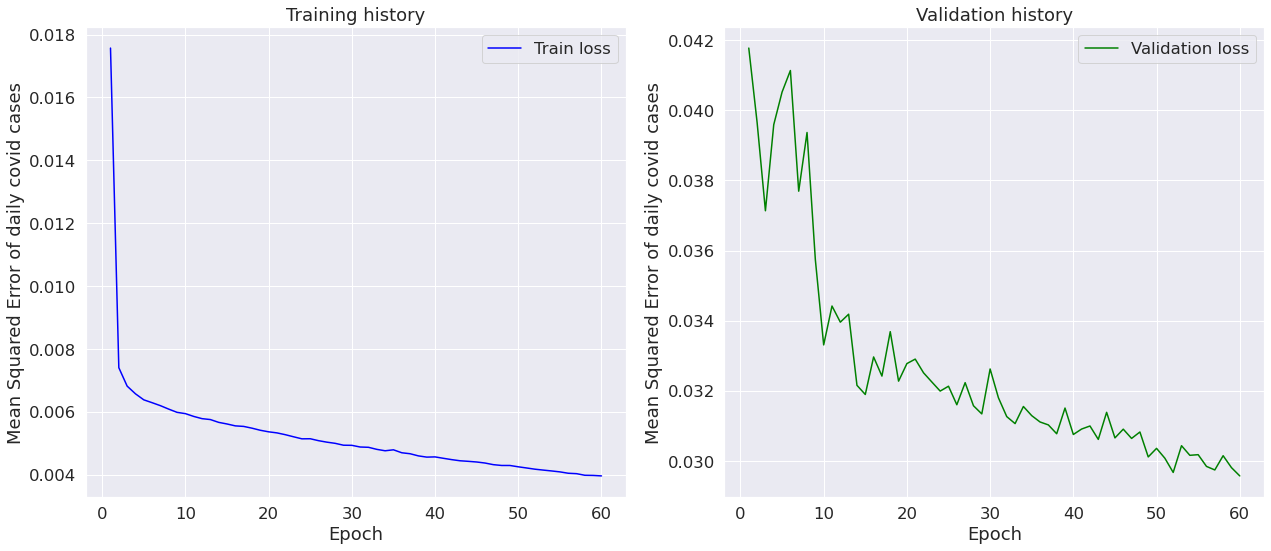

6473

In [17]:
history = trainer.fit(
    model, optimizer, train_batch, validation_batch, checkpointManager, early_stopping_patience=parameterManager.early_stopping_patience
)

plot_history(history, os.path.join(figure_folder, 'history.png'), show=True)
gc.collect()

## Testing

In [18]:
# load the best checkpoint by validation loss
model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
if model is None:
    sys.exit(-1)

Checkpoint restored from output/checkpoints/ckpt-57


### Train predictions

In [19]:
train_batch = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = trainer.predict(model, train_batch)

train_actuals = scale_back(train_actuals, target_scaler, parameterManager.target_sequence_length)
train_preds = scale_back(train_preds, target_scaler, parameterManager.target_sequence_length)

train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')
gc.collect()

  0%|          | 0/664 [00:00<?, ?it/s]

Train MAE 7.2831, RMSE 14.9365, SMAPE 0.93


20

### Validation predictions

In [20]:
validation_preds, validation_actuals, _ = trainer.predict(model, validation_batch)

validation_preds = scale_back(validation_preds, target_scaler, parameterManager.target_sequence_length)
validation_actuals = scale_back(validation_actuals,  target_scaler, parameterManager.target_sequence_length)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

  0%|          | 0/67 [00:00<?, ?it/s]

Validation MAE 29.7303, RMSE 58.6074, SMAPE 1.234


### Test

In [21]:
test_batch = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, _ = trainer.predict(model, test_batch)

test_actuals = scale_back(test_actuals, target_scaler, parameterManager.target_sequence_length) 
test_preds = scale_back(test_preds, target_scaler, parameterManager.target_sequence_length)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

  0%|          | 0/67 [00:00<?, ?it/s]

Test MAE 15.9228, RMSE 22.7008, SMAPE 1.6011


### Delete model

In [22]:
del model
gc.collect()

102

# Result plot

In [23]:
number_of_locations = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'Number of locations {number_of_locations}')
locs = df[parameterManager.col_mappings['ID']].iloc[:number_of_locations, 0].values

Number of locations 70


## Train

Saving output/figures/Summed plot - train.png


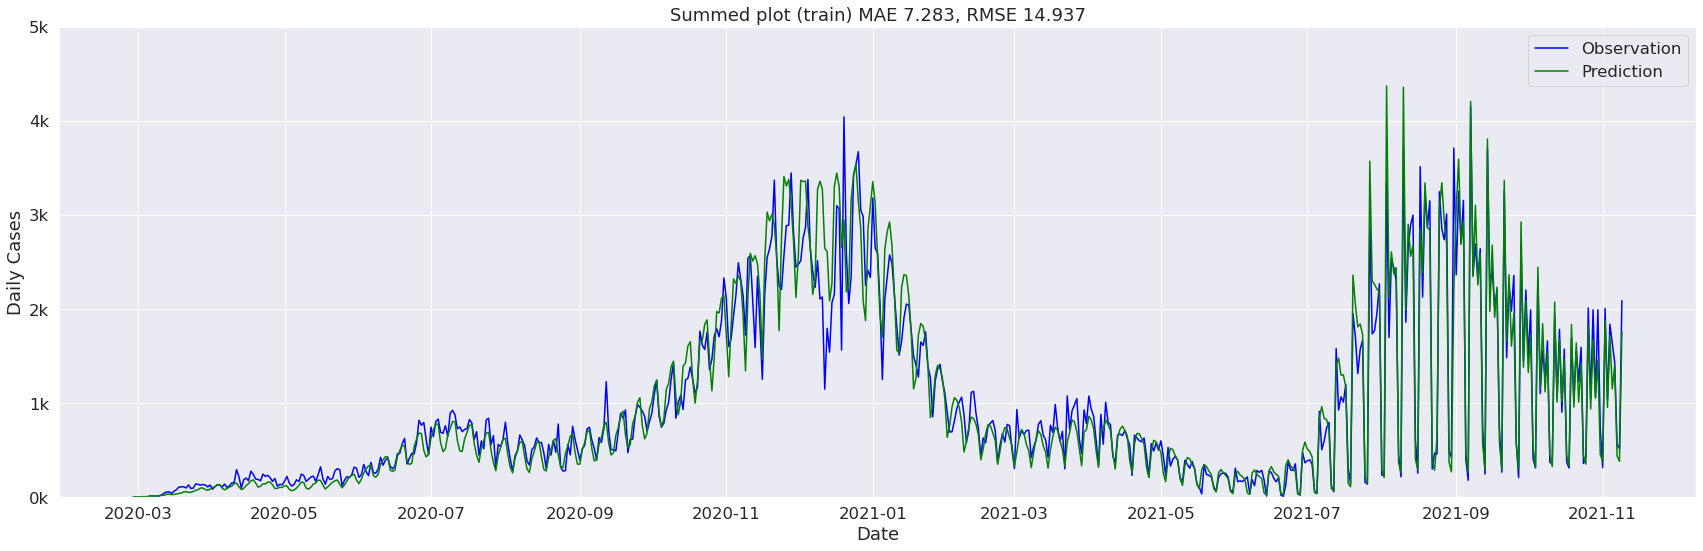

In [24]:
targets, predictions = sumCases(train_actuals, train_preds, number_of_locations)

resultPlotter = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - train', figsize=(24, 8))

## Validation

Saving output/figures/Summed plot - validation.png


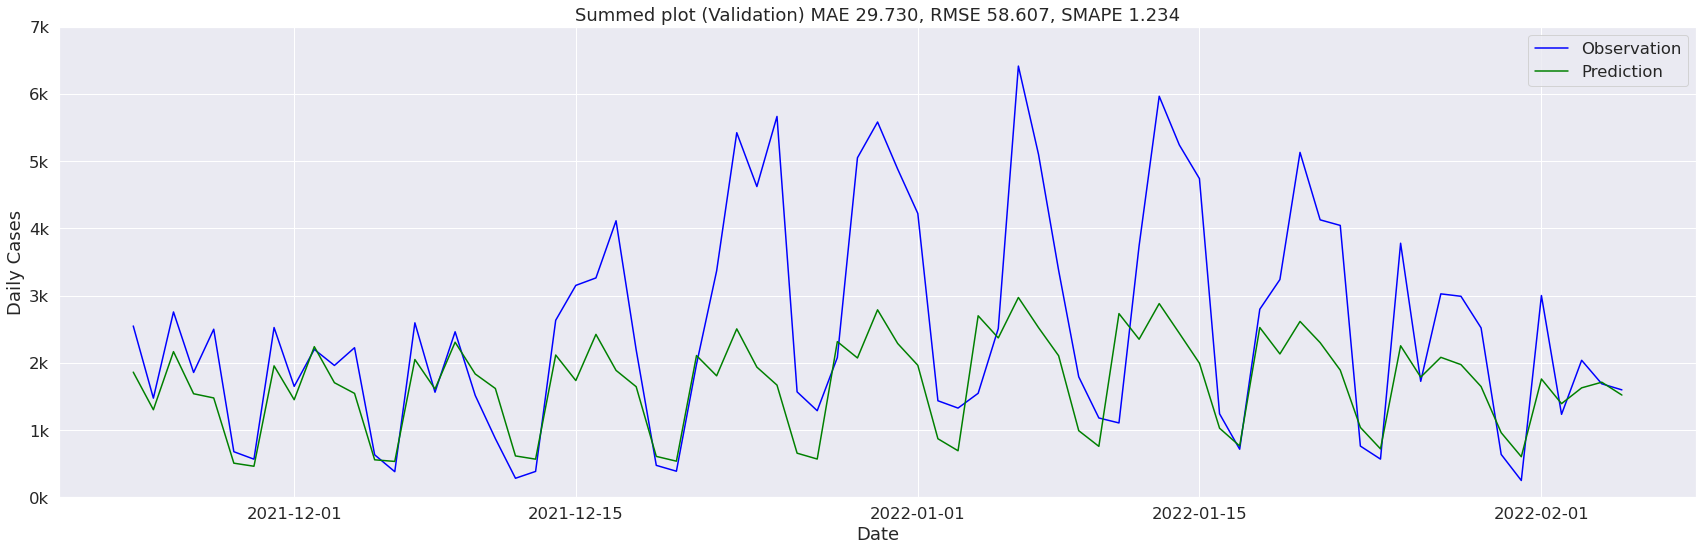

In [25]:
targets, predictions = sumCases(validation_actuals, validation_preds, number_of_locations)
resultPlotter = PlotResults(targets, predictions, parameterManager.validation_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - validation')

## Test

Saving output/figures/Summed plot - test.png


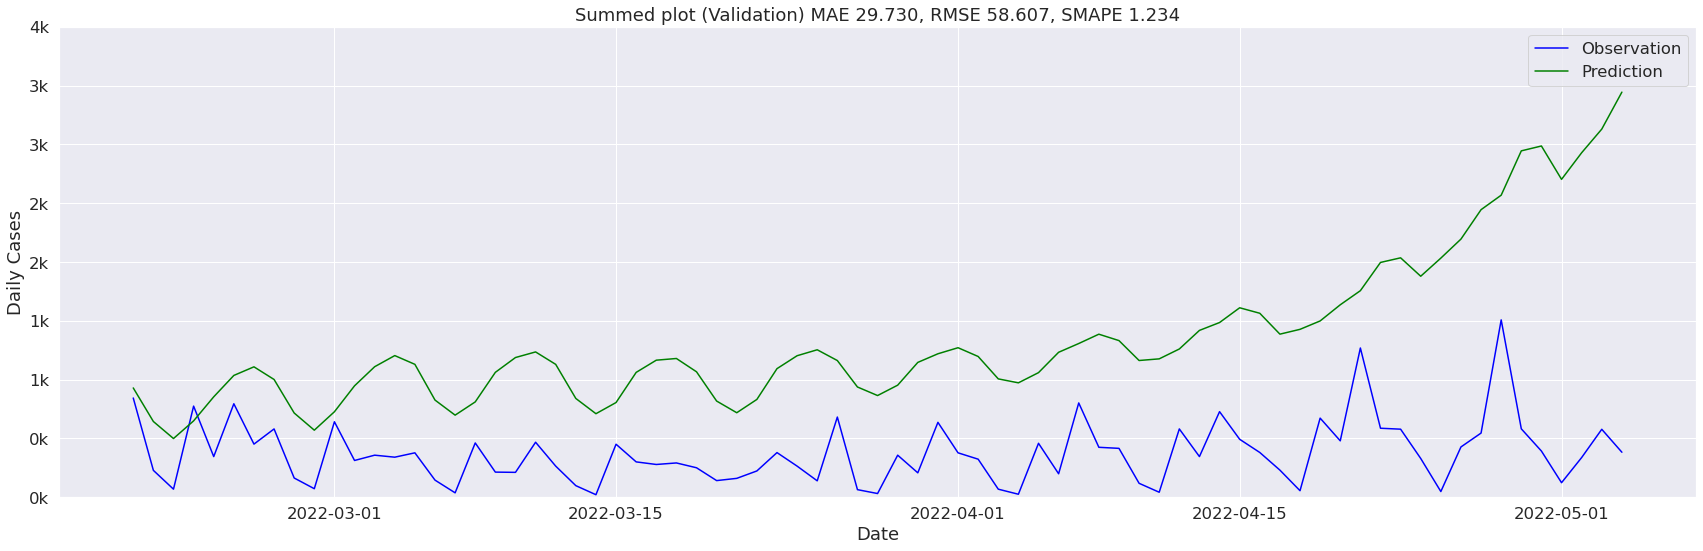

In [26]:
targets, predictions = sumCases(test_actuals, test_preds, number_of_locations)
PlotC = PlotResults(targets, predictions, parameterManager.test_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title, figure_name='Summed plot - test')

# Interpret

Saving output/figures/Static input selection weights by variable.png


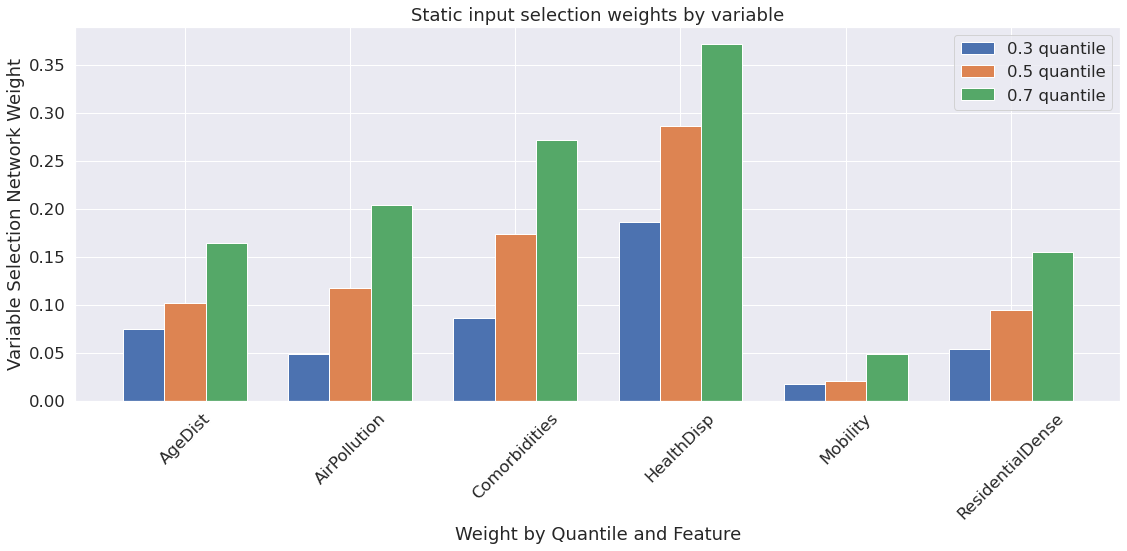

Saving output/figures/Future known input selection weights by variable.png


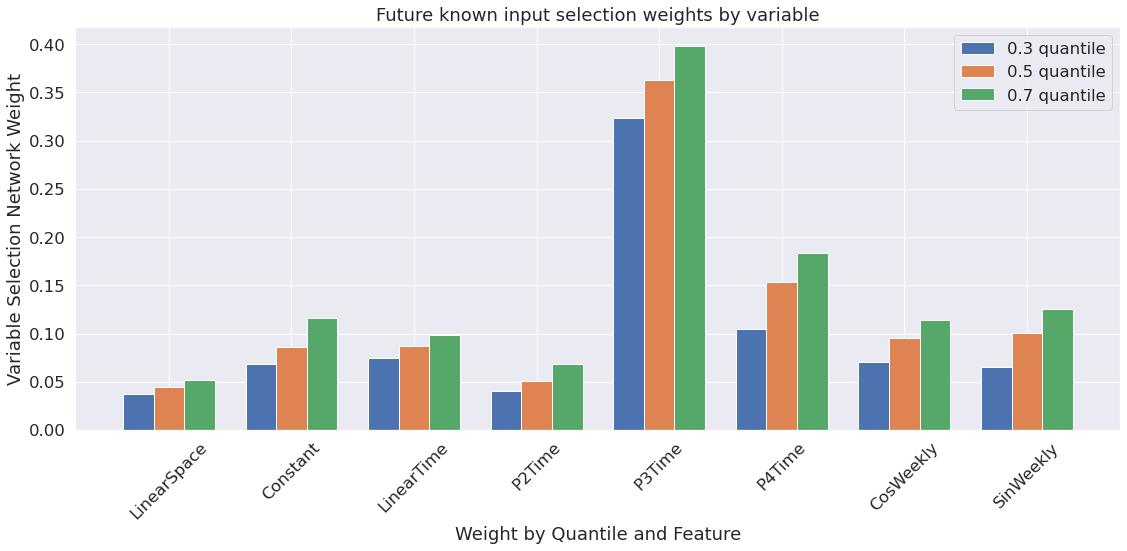

Saving output/figures/Observed input selection weights by variable.png


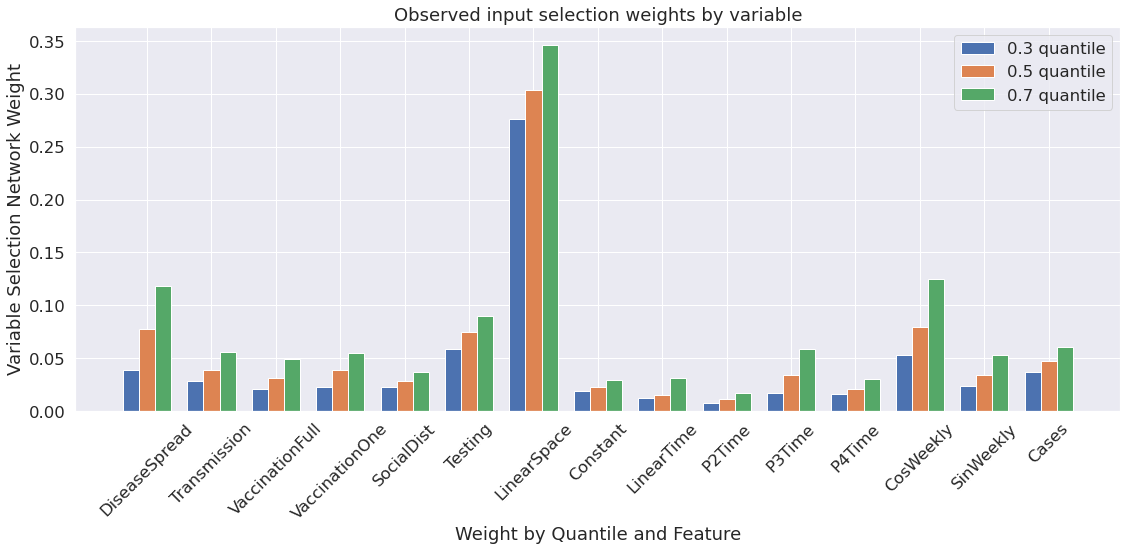

In [27]:
plotter = PlotWeights(parameterManager.col_mappings, train_attn_weights, figure_folder, show=True)
"""## Static variables"""

plotter.plot_static_weights()

"""## Future known input"""

plotter.plot_future_weights()

"""## Observed weights"""

plotter.plotObservedWeights()